# **Final Project - Pneunomia Classification**

### **Characteristics Dataset**

- **Train**: 5216 Images
- **Valid**: 16 Images
- **Test**: 624 Images

### **Model**  

1. **ResNet50**
2. **MobileNet**


### **Success Metrics**
Model performance will be evaluated using:
- **Accuracy**: Proportion of correct predictions over total predictions.  
- **Precision**: Proportion of true positive predictions among all positive predictions.  
- **Recall**: Proportion of true positive predictions among all actual positives.  
- **F1 Score**: Harmonic mean of precision and recall, balancing false positives and false negatives.


In [50]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy

#Kernel Intilizer 
from sklearn.preprocessing import LabelEncoder

# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
#PreTrained Model
from tensorflow.keras.applications import *
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Warnings Remove 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160) 

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Load Data</p>


In [3]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [4]:
df_train.head()

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [5]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [6]:
df_test.head()

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [7]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'train',
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = IMG_SIZE,
  batch_size = BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'train',
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = IMG_SIZE,
  batch_size = BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


I0000 00:00:1763997223.943404      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763997223.944139      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 images belonging to 2 classes.


# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Visualize Labels</p>


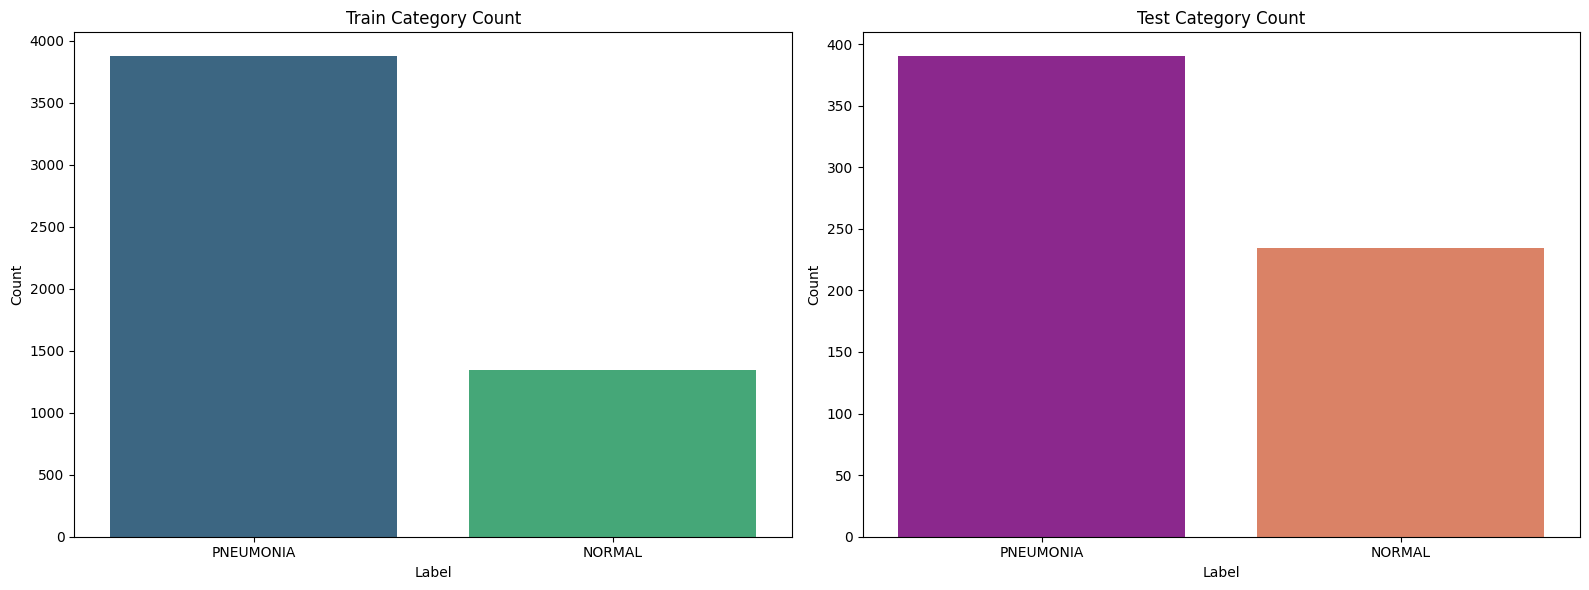

In [9]:
count_train = df_train['label'].value_counts()
count_test = df_test['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    x=count_train.index,
    y=count_train.values,
    ax=axs[0],
    palette="viridis"
)
axs[0].set_title("Train Category Count")
axs[0].set_xlabel("Label")
axs[0].set_ylabel("Count")

sns.barplot(
    x=count_test.index,
    y=count_test.values,
    ax=axs[1],
    palette="plasma"
)
axs[1].set_title("Test Category Count")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Visualize Images</p>


In [10]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    
    num_images = min(num_images, len(image_filenames))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')  
        axes[i].set_title(image_filename)  
    
    plt.tight_layout()
    plt.show()

# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:white;">Normal Images</p>

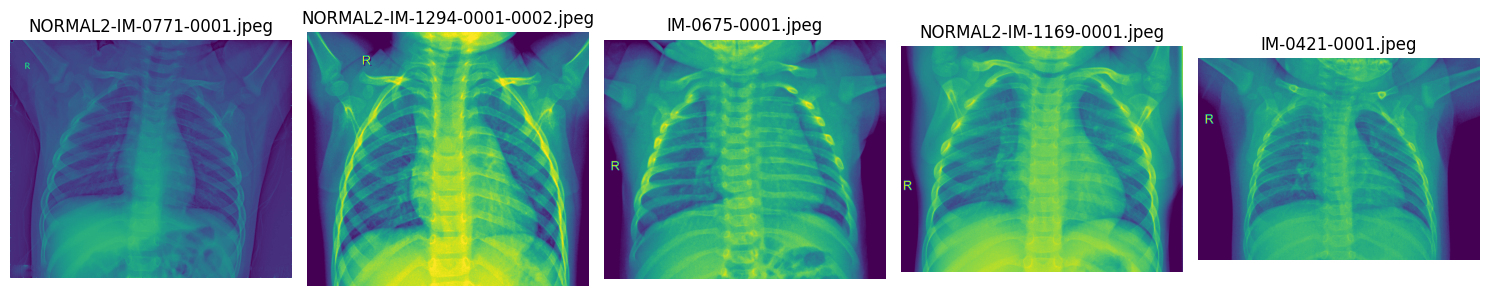

In [11]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

visualize_images(path_to_visualize, num_images=5)

# <p style="font-family:newtimeroman;font-size:100%;text-align:center;color:white;">Pneunomia Images</p>

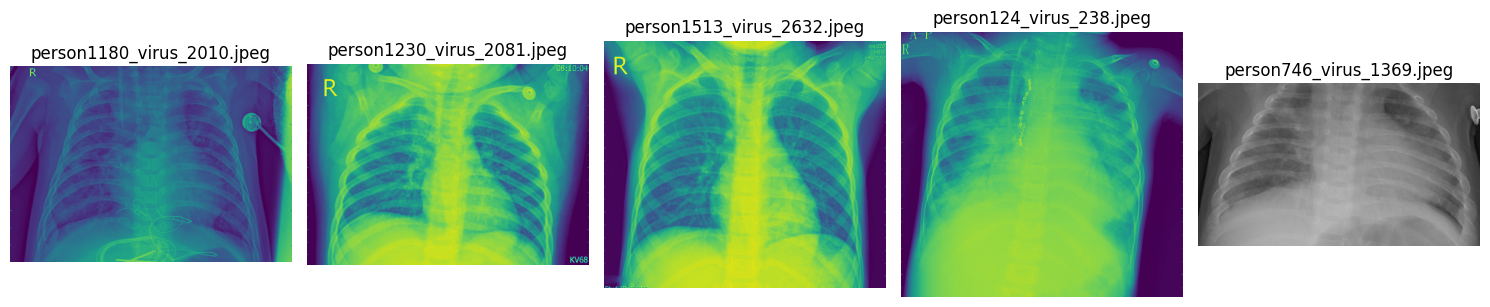

In [12]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

visualize_images(path_to_visualize, num_images=5)

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Processing</p>


In [13]:
preprocess_inputv1 = tf.keras.applications.resnet_v2.preprocess_input
preprocess_inputv2 = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.07),
  tf.keras.layers.RandomZoom(0.07),
  tf.keras.layers.RandomWidth(0.07),
  tf.keras.layers.RandomHeight(0.007)
])

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Modelling & Training Model 1</p>


In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_modelv1 = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_modelv1.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [17]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
X1 = data_augmentation(inputs)
X1 = preprocess_inputv1(X1)
X1 = base_modelv1(X1, training = False)
X1 = global_average_layer(X1)
X1 = tf.keras.layers.Dropout(0.13)(X1)
outputs = prediction_layer(X1)
modelv1 = tf.keras.Model(inputs, outputs)

In [18]:
modelv1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [19]:
base_learning_rate = 0.0005
modelv1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [20]:
%%time

history = modelv1.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    verbose=0)

I0000 00:00:1763997242.566029     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


CPU times: user 28min 53s, sys: 47.5 s, total: 29min 41s
Wall time: 8min 20s


# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Modelling & Training Model 2</p>

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_modelv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_modelv2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
#model 2
inputs = tf.keras.Input(shape = IMG_SHAPE)
x2 = data_augmentation(inputs)
x2 = preprocess_inputv2(x2)
x2 = base_modelv2(x2, training = False)
x2 = global_average_layer(x2)
x2 = tf.keras.layers.Dropout(0.13)(x2)
outputs = prediction_layer(x2)
modelv2 = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0005

modelv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [25]:
modelv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, None, None,     │     2,257,984 │
│ (Functional)                    │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
%%time 
    
history2 = modelv2.fit(train_dataset,
                     epochs=25,
                     validation_data=val_dataset,
                     verbose=0)

CPU times: user 23min 46s, sys: 33.4 s, total: 24min 19s
Wall time: 6min 38s


In [27]:
modelv1.save("model_v1.h5")
modelv2.save("model_v2.h5")

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Val Evaluation Model 1</p>


In [ ]:
testgen= tf.keras.preprocessing.image.ImageDataGenerator()
testdata=testgen.flow_from_directory(data_dir+'test', 
                                    shuffle=False,
                                    batch_size=BATCH_SIZE,
                                    target_size=(IMG_SIZE),
                                    class_mode="binary")

In [30]:
validation_loss, validation_accuracy = modelv1.evaluate(val_dataset)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9613 - loss: 0.0887
Validation Loss: 0.09906475245952606
Validation Accuracy: 0.9539788961410522


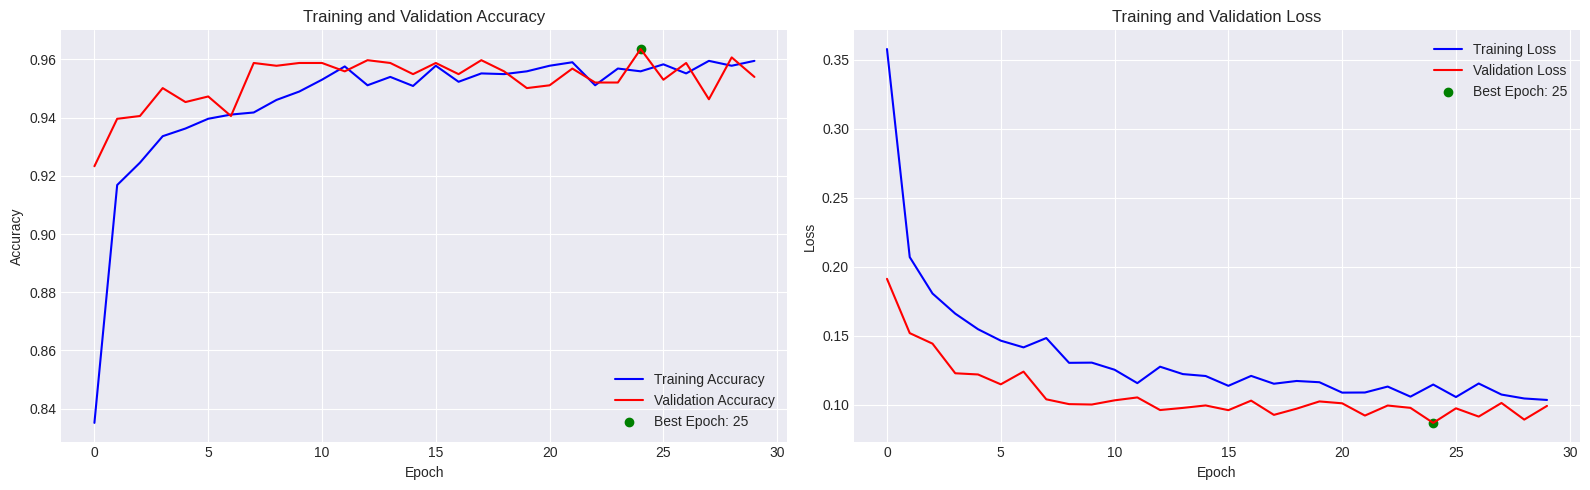

In [32]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Val Evaluation Model 2</p>


In [33]:
validation_loss, validation_accuracy = modelv2.evaluate(val_dataset)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9021 - loss: 0.1748
Validation Loss: 0.19814445078372955
Validation Accuracy: 0.8897411227226257


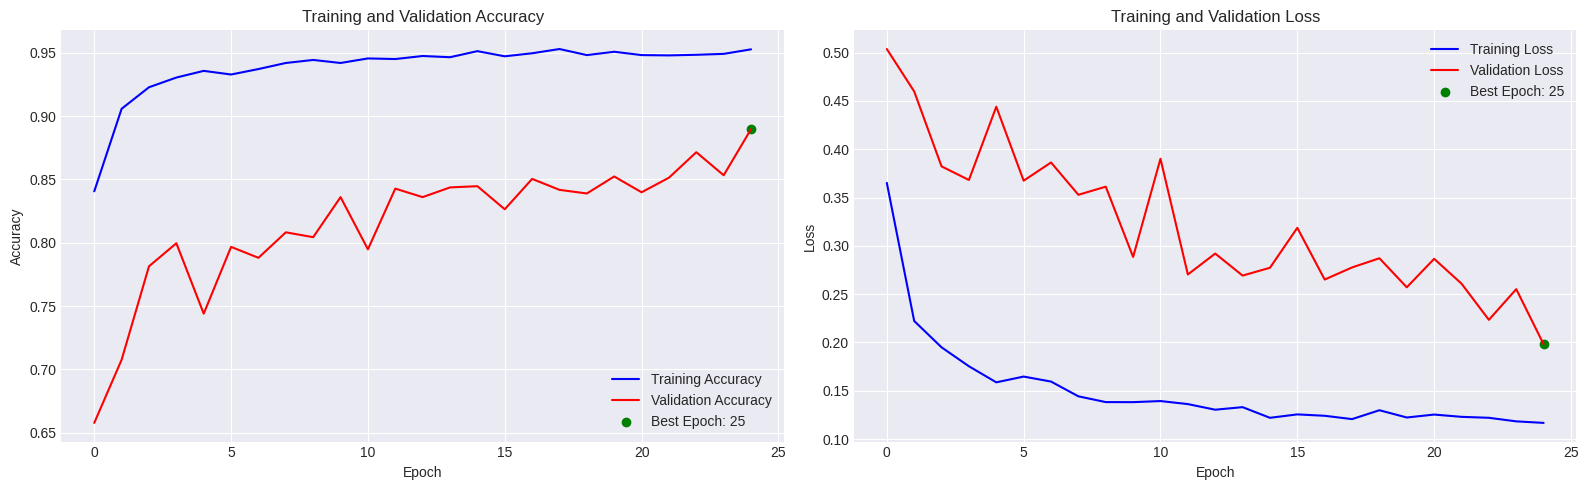

In [36]:
best_epoch = history2.history['val_accuracy'].index(max(history2.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history2.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history2.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history2.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history2.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history2.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history2.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# <p style="font-family:newtimeroman;font-size:150%;text-align:center;color:white;">Test Prediction</p>


In [52]:
test_loss, test_accuracy = modelv1.evaluate(testdata)
test_accuracy, test_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.8067 - loss: 0.5925


(0.8653846383094788, 0.39642244577407837)

In [53]:
y_true = testdata.classes  

y_pred_prob = modelv1.predict(testdata)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.70      0.80       234
   PNEUMONIA       0.84      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624



Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step


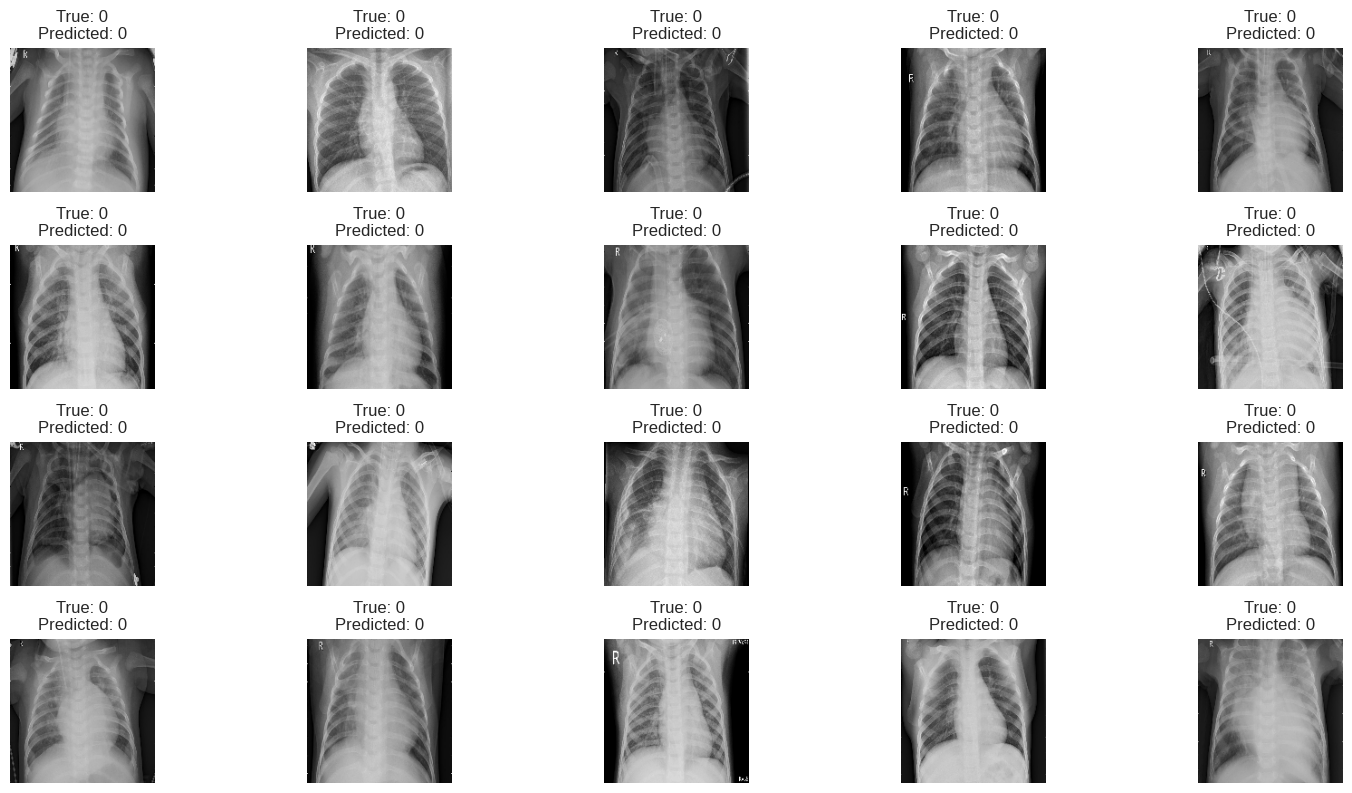

In [54]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMG_SIZE,
    batch_size=32)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()
    

class_labels = testdata.classes
print('Testing Images:')
plot_images_with_predictions(modelv1, test_ds, class_labels, num_images=20)